# Random Forest Third Trial
## Summary of Tasks:
1. Encode feature variables - improvement over trial 1 - encode job using dummy encoding (better than frequency encoding)
2. SMOTE for handling data imbalance
3. Stratified K-Fold cross validation to handle the data imbalance
4. Train random forest model
5. Use grid search to find best hyperparameters that produce best f1 score

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [86]:
data = pd.read_csv('../data/bank.csv')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no


## Encoding categorical variables
One hot encoding: marital, poutcome, contact, job, y, education

Binary encoding: loan, housing, default

sin/cosine encoding: month, day_of_week

In [87]:
# Encoding categorical data
# Using ordinal encoding for y
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder(categories=[['no','yes']])
data['y_encoded'] = encoder.fit_transform(data[['y']])
data['pdays'] = data['pdays'].replace(999, 0)


# Using dummy encoding to encode marital, poutcome, contact, job
to_dummy_cols = pd.DataFrame(data[['marital', 'poutcome','contact', 'job']])
dummy_cols = pd.get_dummies(to_dummy_cols)


# Using binary encoding for loan, housing, default, y
from category_encoders import BinaryEncoder 
encoder = BinaryEncoder(cols =['loan', 'housing', 'default']) 
# Transforming the column after fitting
newdata = encoder.fit_transform(data[['loan', 'housing', 'default']])


# Using ordinal encoding for education
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder(categories=[["illiterate","unknown","basic.4y","basic.6y","basic.9y","high.school","professional.course","university.degree"]])
data['education_encoded'] = encoder.fit_transform(data[['education']])

# Sin/cosine encoding for month, day_of_week
# Map categorical values to numerical values
month_mapping = {month: i+1 for i, month in enumerate(['jan', 'feb', 'mar', 'apr', 'may', 'jun', 
                                                       'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])}
day_mapping = {day: i+1 for i, day in enumerate(['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun'])}

data['month_num'] = data['month'].map(month_mapping)
data['day_num'] = data['day_of_week'].map(day_mapping)

# Sine and Cosine Encoding
data['month_sin'] = np.sin(2 * np.pi * data['month_num'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month_num'] / 12)
data['day_sin'] = np.sin(2 * np.pi * data['day_num'] / 7)
data['day_cos'] = np.cos(2 * np.pi * data['day_num'] / 7)


# concatenating dataframe
data = pd.concat([data, newdata, dummy_cols], axis = 1) 
# dropping old column 
data = data.drop(['loan', 'housing', 'y','default','marital', 'poutcome','contact','job','month', 'day_of_week', 'month_num', 'day_num','education'], axis = 1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 43 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   41188 non-null  int64  
 1   duration              41188 non-null  int64  
 2   campaign              41188 non-null  int64  
 3   pdays                 41188 non-null  int64  
 4   previous              41188 non-null  int64  
 5   emp.var.rate          41188 non-null  float64
 6   cons.price.idx        41188 non-null  float64
 7   cons.conf.idx         41188 non-null  float64
 8   euribor3m             41188 non-null  float64
 9   nr.employed           41188 non-null  int64  
 10  y_encoded             41188 non-null  float64
 11  education_encoded     41188 non-null  float64
 12  month_sin             41188 non-null  float64
 13  month_cos             41188 non-null  float64
 14  day_sin               41188 non-null  float64
 15  day_cos            

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from collections import Counter

X = np.array(data.drop(['y_encoded'], axis=1))
y = data[['y_encoded']]
# Feature Scaling for input features.
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=31, test_size=0.2)

# Counting the number of instances in each class before oversampling
print('Before')
print(len(y_train['y_encoded']))

# Oversampling the train dataset using SMOTE + Tomek
smtom = SMOTETomek(random_state=139)
X_train_smtom, y_train_smtom = smtom.fit_resample(X_train, y_train)

# Counting the number of instances in each class after oversampling
print('After')
print(len(y_train_smtom['y_encoded']))



Before
32950
After
58028


In [89]:
# STRATIFIES K-FOLD CROSS VALIDATION { 10-fold }

# Import Required Modules.
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Create classifier object.
rfc_skf = RandomForestClassifier(n_jobs=-1)

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
f1_stratified = []
y = np.array(data[['y_encoded']])
for train_index, test_index in skf.split(X, y):
	X_train_fold, X_test_fold = X[train_index], X[test_index]
	y_train_fold, y_test_fold = y[train_index], y[test_index]
	# Oversampling the train dataset using SMOTE + Tomek
	smtom = SMOTETomek(random_state=139)
	X_train_fold, y_train_fold= smtom.fit_resample(X_train_fold, y_train_fold)
	rfc_skf.fit(X_train_fold, y_train_fold)
	y_predict = rfc_skf.predict(X_test_fold)
	fold_f1 = f1_score(y_test_fold, y_predict, average='binary')  # Use 'binary' for binary classification
	f1_stratified.append(fold_f1)

# Print the output.
print('List of possible f1:', f1_stratified)
print('\nMaximum f1 That can be obtained from this model is:',
	max(f1_stratified)*100, '%')
print('\nMinimum f1:',
	min(f1_stratified)*100, '%')
print('\nOverall f1:',
	mean(f1_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(f1_stratified))


List of possible f1: [0.596244131455399, 0.5642857142857143, 0.5600961538461539, 0.5486518171160609, 0.5959475566150179, 0.5795724465558195, 0.5522208883553421, 0.5349693251533743, 0.6144994246260069, 0.5555555555555556]

Maximum f1 That can be obtained from this model is: 61.449942462600696 %

Minimum f1: 53.49693251533743 %

Overall f1: 57.02043013564444 %

Standard Deviation is: 0.025324152664351837


In [90]:
# Train basic random forest model now
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import *

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=31, test_size=0.2)

rfc = RandomForestClassifier(n_jobs=-1, random_state=31, class_weight='balanced')
rfc.fit(X_train_smtom, y_train_smtom)


# Checking scores
y_predict = rfc.predict(X_test)
y_predict_train = rfc.predict(X_train_smtom)
accuracy_test = accuracy_score(y_predict, y_test)
accuracy_train = accuracy_score(y_predict_train, y_train_smtom)
precision_test = precision_score(y_predict, y_test)
precision_train = precision_score(y_predict_train, y_train_smtom)
recall_test = recall_score(y_predict, y_test)
recall_train = recall_score(y_predict_train, y_train_smtom)
f1_test = f1_score(y_predict, y_test)
f1_train = f1_score(y_predict_train, y_train_smtom)

# Printing out results
# Predicting the accuracy score for Random Forest Classifier 
print('\n')
print('-------Random Forest Classifier-------')
print('accuracy for test is', accuracy_test)
print('accuracy for train is', accuracy_train)
print('\n')
print('precision for test is', precision_test)
print('precision for train is', precision_train)
print('\n')
print('recall for test is', recall_test)
print('recall for train is', recall_train)
print('\n')
print('f1 for test is', f1_test)
print('f1 for train is', f1_train)
print('\n')


print(classification_report(y_test, y_predict))




-------Random Forest Classifier-------
accuracy for test is 0.9130857004127215
accuracy for train is 1.0


precision for test is 0.6162402669632926
precision for train is 1.0


recall for test is 0.5989189189189189
recall for train is 1.0


f1 for test is 0.6074561403508771
f1 for train is 1.0


              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95      7339
         1.0       0.60      0.62      0.61       899

    accuracy                           0.91      8238
   macro avg       0.78      0.78      0.78      8238
weighted avg       0.91      0.91      0.91      8238



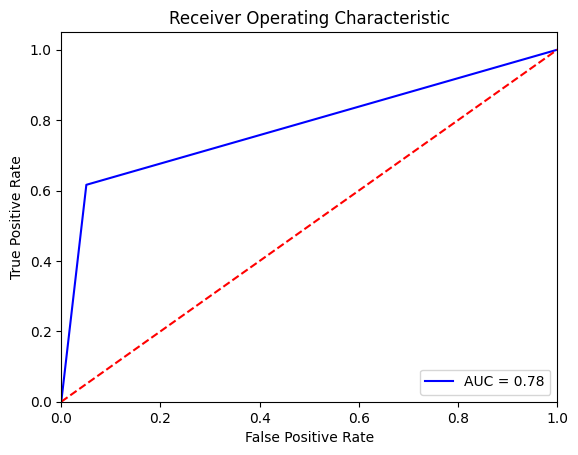

In [91]:
# ROC, Area Under Curve
preds = rfc.predict_proba(X_scaled)[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_predict)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [92]:
rf = RandomForestClassifier(random_state=31, n_jobs=-1)

params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200],
    'max_features': ['auto', 'sqrt', 'log2'],

}

from sklearn.model_selection import GridSearchCV

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 5,
                           n_jobs=-1, verbose=1, scoring="f1")

grid_search.fit(X_train, y_train)
print(grid_search.best_score_)
rf_best = grid_search.best_estimator_
print(rf_best)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


KeyboardInterrupt: 